In [1]:
# %load src/model_selection.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import roc_curve, precision_score, recall_score,roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, precision_score, recall_score,  classification_report, make_scorer

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, LabelBinarizer
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from src.plot_confusion_matrix import plot_confusion_matrix
%matplotlib inline
pd.options.display.max_colwidth = 50

import pickle

from datetime import date
import calendar

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

* Retrieve raw data from pipeline.py.
* Merge standardized geo-spatial (city, admin1, admin2, country) to the master data.
* Enrich features based on the "tickets_type" field - unpacking lists of dictionaries.

In [2]:
# %load src/merging geospatial info.py
import pandas as pd
import pickle


rg = pd.read_pickle('data/rg.pkl')

get_ipython().run_line_magic('run', 'src/pipeline')
D = FraudData('data/data.json')
df = D.get_enriched_df()





In [3]:
df.label.value_counts()

0    13044
1     1293
Name: label, dtype: int64

In [4]:
loc = df[['venue_latitude','venue_longitude','object_id']]
loc = loc[~loc['venue_latitude'].isnull()]

loc2 = loc.join(rg)
loc3 = loc2.drop(['venue_latitude', 'venue_longitude'],axis = 1)
df = df.merge(loc3, how='left', right_on = 'object_id', left_on = 'object_id')




In [5]:
idx= df.set_index(['object_id']).ticket_types.apply(pd.Series).stack().index

tmp = pd.DataFrame(df.set_index(['object_id']).ticket_types.apply(pd.Series).stack().values.tolist(),index=idx).reset_index().drop('level_1',1)
tmp_sum = tmp.groupby('event_id').agg({'cost': ['min', 'max'],'quantity_total' : 'sum' }).reset_index()
tmp_sum.columns = [' '.join(col).strip() for col in tmp_sum.columns.values]

tmp_sum.isnull().sum()

event_id              0
cost min              0
cost max              0
quantity_total sum    0
dtype: int64

In [7]:
df = df.merge(tmp_sum, how='left', left_on = 'object_id', right_on = 'event_id')
df['ticket_tiers_num'] = df['ticket_types'].apply(lambda x: len(x))

for col in ['cost min', 'cost max','quantity_total sum']:
    df[col]=df[col].apply(lambda x: 0 if pd.isnull(x) else x)

df['day_of_week'] = df['ec_weekday'].apply(lambda x: calendar.day_name[x])

df.listed.replace(('y', 'n'), (1, 0), inplace=True)

df['payout_type'] = df['payout_type'].replace(r'^\s*$', np.nan, regex=True)

In [8]:
df['cost max'].describe()

count     14337.000000
mean        191.936397
std        1373.360284
min           0.000000
25%          15.000000
50%          32.080000
75%          93.510000
max      100000.000000
Name: cost max, dtype: float64

In [9]:
df['cost min'].describe()

count    14337.000000
mean        67.161208
std        287.004440
min         -1.160000
25%          4.000000
50%         17.500000
75%         45.000000
max      15989.800000
Name: cost min, dtype: float64

In [83]:
df['sale_duration2'].describe()

count    14337.000000
mean        50.576759
std         59.678090
min      -1094.000000
25%         17.000000
50%         35.000000
75%         63.000000
max        980.000000
Name: sale_duration2, dtype: float64

In [10]:
n_feat = ['sale_duration', 'user_event_delta', 'cost min', 'cost max', 'quantity_total sum', 
         'body_length', 'fb_published', 'has_analytics', 'has_logo', 'listed',
       'name_length', 'ticket_tiers_num','venue_longitude','venue_latitude' ]

In [11]:
c_feat = ['currency','payout_type','day_of_week']

In [12]:
df_cat = pd.get_dummies(df[c_feat], dummy_na=True, drop_first=True)

In [13]:
df_cat_n = df[n_feat].join(df_cat)
# df_cat_n.dtypes

In [14]:
hours = pd.get_dummies(df['ec_hour'].astype(str),prefix= 'hour_')
feat = df_cat_n.join(hours)

In [15]:
y = df.pop('label').values
X = feat.copy()



#### Model Selection

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=42)

In [17]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10752, 54), (3585, 54), (10752,), (3585,))

In [18]:
# List of classifiers
lr = LogisticRegression()
rf = RandomForestClassifier(n_jobs=-1)
gb = GradientBoostingClassifier()



In [19]:
imputation = SimpleImputer(strategy='mean',fill_value=0)
pipeline = (Pipeline([
                
                ('scale', StandardScaler()),
                ('impute',imputation),
                ('clf', LogisticRegression())
                ]))

In [20]:
# cross-validation of the training data.

def eval_scores(clf):
    recall = cross_val_score(clf, X_train, y_train,  scoring='recall')
    precision = cross_val_score(clf, X_train, y_train, scoring='precision')
    f1 = cross_val_score(clf, X_train, y_train, scoring='f1')

    print('Precision', np.mean(precision))
    print('Recall', np.mean(recall))
    print('F1', np.mean(f1))

In [21]:
eval_scores(pipeline)

Precision 0.8554164472121532
Recall 0.4917599918459912
F1 0.6232744672229934


In [22]:
def score_model(pipeline, X_train, y_train, X_test,y_test, threshold = 0.5):
    for classifier in [lr, rf,gb]:
        pipeline.set_params(clf = classifier)
        pipeline.fit(X_train, y_train)
    #     predicted = pipeline.predict(X_test)
        probs = pipeline.predict_proba(X_test)[:, 1]
        preds = probs.copy()
        preds[preds>=threshold] = 1
        preds[preds<threshold] = 0
        results = np.empty(preds.shape)


        print('---------------------------------')
        print(str(classifier))
        print('-----------------------------------')
        accuracy = accuracy_score(y_test, preds)
        precision = precision_score(y_test, preds)
        recall = recall_score(y_test, preds)

        print(f"Accuracy Score: {accuracy}")
        print(f"Precision Score: {precision}")
        print(f"Recall Score: {recall}")


In [23]:
score_model(pipeline, X_train, y_train, X_test,y_test, threshold = 0.5)

---------------------------------
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
-----------------------------------
Accuracy Score: 0.9489539748953975
Precision Score: 0.8804347826086957
Recall Score: 0.5015479876160991
---------------------------------
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
-----------------------------------
Accuracy Score: 0.9760111576011158
Precision Score: 0.927797833935018


#### When the threshold increases from 0.5 to 0.75, the peroformance of Logistic Regression and Random Forest gets much worse in terms of the recall score. The recall score of Gradient Boosting CLF gets worse but not as much as the other two models.

In [24]:
score_model(pipeline, X_train, y_train, X_test,y_test, threshold = 0.75)

---------------------------------
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
-----------------------------------
Accuracy Score: 0.9364016736401674
Precision Score: 0.9130434782608695
Recall Score: 0.32507739938080493
---------------------------------
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
-----------------------------------
Accuracy Score: 0.9548117154811715
Precision Score: 0.987878787878787

In [25]:
pipeline.set_params(clf = gb)
pipeline.fit(X_train,y_train)
model = pipeline.steps[2][1]


In [26]:
feature_names = list(X_train.columns)

feature_importances = model.feature_importances_ / np.sum(model.feature_importances_)

feat_df = pd.DataFrame(feature_importances, index = feature_names)
feat_df.sort_values(0, ascending = False, inplace=True)

In [27]:
feat_df[:20]

,0
payout_type_nan,0.394240
sale_duration,0.277335
user_event_delta,0.204145
cost min,0.027692
cost max,0.025644
venue_longitude,0.013696
venue_latitude,0.011371
body_length,0.011204
payout_type_CHECK,0.009193
quantity_total sum,0.008936


In [65]:
feat_short_lst = feat_df[:6].index.to_list()
feat_short_lst

['payout_type_nan',
 'sale_duration',
 'user_event_delta',
 'cost min',
 'cost max',
 'venue_longitude']

In [66]:
score_model(pipeline, X_train[feat_short_lst], y_train, X_test[feat_short_lst], y_test, threshold = 0.5)

---------------------------------
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
-----------------------------------
Accuracy Score: 0.9352859135285914
Precision Score: 0.9099099099099099
Recall Score: 0.3126934984520124
---------------------------------
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
-----------------------------------
Accuracy Score: 0.9735006973500697
Precision Score: 0.8986013986013986

In [67]:
pipeline.set_params(clf = rf)
pipeline.fit(X_train[feat_short_lst],y_train)
predicted = pipeline.predict(X_test[feat_short_lst])

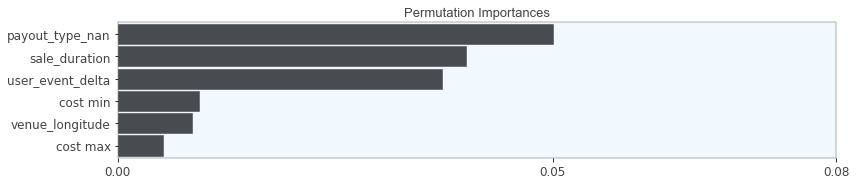

In [75]:
from rfpimp import *

imp = importances(pipeline, X_test[feat_short_lst], y_test, n_samples=-1)

viz = plot_importances(imp[0:10],  yrot=0,
                            label_fontsize=12,
                            width=12,
                            minheight=1.5,
                            vscale=2.0,
                            imp_range=(0, imp['Importance'].max() + .03),
                            color='#484c51',
                            bgcolor='#F1F8FE',  # seaborn uses '#F1F8FE'
                            xtick_precision=2,
                            title='Permutation Importances')

viz.view()

In [72]:
imp

,Importance
Feature,
payout_type_nan,0.044073
sale_duration,0.038773
user_event_delta,0.038215
cost min,0.009763
venue_longitude,0.007252
cost max,0.005300


#### Apply the model to the entire dataset

In [76]:
pipeline.set_params(clf = rf)
pipeline.fit(X[feat_short_lst],y)


Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('impute', SimpleImputer(copy=True, fill_value=0, missing_values=nan, strategy='mean',
       verbose=0)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_f..._jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [77]:
model = pipeline.steps[2][1]

pickle.dump(model,open('data/rf_model_ks.p','wb'))